# Multivariate n-lagged Random Forest  

For timeseries plotting, autocorrelations and correlations consult the eda_input_prep.ipynb notebook.

From:  https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Random Forest models leverage the value of many trained decision trees - making it an ensemble technique - to come up with an estimator that delivers the best balance between goodness of fit (low bias) and generalization (low variance).  In regression modelling this means averaging the output of the estimates, while in classification this means a "win by votes".  

Timeseries data can be processed to be modelled using supervised learning algotithms like Random Forest.  The data must be "lagged", that is, the model is prompted to predict a target at time t using information from time t-1 (or t-n if n lags are imposed).  And this can be done for an autoregression, where a target is predicted based only on past values of itself, or it can be done for a multivariate scenario where a target variable is predicted on past values of itself and past values for the feature variables that impact on the target.

Here is an overview of the steps carried out in this effort:
* The raw dataset must be lagged to the desired lag value, and the lagged versions of the variables must be collated for input
> For the multivariate exercise, a lag of 1 will first be attempted to get a successful execution, then 4, then perhaps 8.
* The variables are split into training and test datasets
* The RandomForest is configured and fit on training data
* Predicted values are generated as "one-step" walking forecast predictions on a model re-fit with the training dataset and the last-used test data point/row.  
* These one-step walking forecast predictions are compared to their actual observations for plotting and the calculation of mean absolute error (MAE).  This mirrors a set-up where models are updated real-time on observed data as it is available. 
* Predictions are also produced for a "static model" that is fit only once on the training data, and the test data is input in one step to obtain the predictions.  Plots of the predicted and expected values are produced and the MAE is calculated.

### Stationarity   

In the eda notebooks, the data was found to be stationary by the Augmented Dickey-Fuller test.

https://datascience.stackexchange.com/questions/30362/checking-for-stationarity-in-lstm#:~:text=You%20may%20want%20to%20force,you%20a%20boost%20in%20performance.  

To check for stationarity in Python, consult the following:  
https://machinelearningmastery.com/time-series-data-stationary-python/  

Tests for stationarity, generally:  

"There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data."  (Analytics Vidhya)  

### Predicting on a Real-Time Fitted Model  

One can imagine two scenarios, generally:  

1.  One where a model is fit on a large and rich set of data, the fitted model is used for any new observations that come in, and a model refresh occurs after some set of conditions have been met (time, significant change in process, model performance degradation, etc).

2.  Another where a model is fit also on a fairly large and rich set of data, it generates predictions, but as new observations are recorded, the model is re-fit with the prior history and the new observations, which then generates predictions on a presumably more up-to-date model.

The below presents the second scenario and its results, and below this is the first scenario, "static model" predictions.  Comments on the pitfalls of real-time model refitting are found in the second section.

## Models  


### Preliminary Settings to Import Modules and Data  

In [1]:
import sys
import os
print("Before anything is modified here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())
os.chdir('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue')
sys.path.append('C:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\src')
print("\nNow that things have been modified, here are the system path and the current working directory:")
print(sys.path)
print(os.getcwd())

Before anything is modified here are the system path and the current working directory:
['c:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\notebooks', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\python310.zip', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\DLLs', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds', '', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\win32\\lib', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\lib\\site-packages\\Pythonwin']
c:\Users\ron_d\lhl_capstone\multivariate_timeseries_forecasting_dengue\notebooks

Now that things have been modified, here are the system path and the current working directory:
['c:\\Users\\ron_d\\lhl_capstone\\multivariate_timeseries_forecasting_dengue\\notebooks', 'c:\\Users\\ron_d\\anaconda3\\envs\\lhl_ds\\python310.

In [2]:
import numpy as np
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from timeseries_data_prep import series_to_supervised_mv, train_test_split_rows_reserved
from one_step_forecasts import random_forest_forecast, walk_fwd_validation_rf

### Data Import and Preparation  

In [3]:
# Get the absolute path to the project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Adjust the path to your data file
data_file_path = os.path.join(project_dir, 'multivariate_timeseries_forecasting_dengue', 'data', 'sj_df.csv')

# Read the CSV using the relative path
sj_df = pd.read_csv(data_file_path, header=0, index_col=0)

# For input to series_to_supervised
values = sj_df.values

# Set print options to display more rows and columns
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

# Commented out as the lag, n_in, is changed from one case to the next in this notebook.  It's called in each case.
# transform the time series data into supervised learning
#data = series_to_supervised_mv(sj_df_cases_list, n_in=1) # one time lag for my univariate set-up

### Multivariate Random Forest Timeseries Model with lag 1

With lagged input as first column: 
     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var6(t-1)  \
1          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
2          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
3          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
4          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
5          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
932        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   
933        3.0  -0.038000  -0.016833   0.119371   0.066386  298.081429   
934        1.0  -0.155200  -0.052750   0.137757   0.141214  297.460000   
935        3.0   0.001800  -0.052750   0.203900   0.209843  297.630000   

      var7(t-1)   var8(t-1)  var9(t-1)  var10(t-1)  ...     var6(t)  \
1   

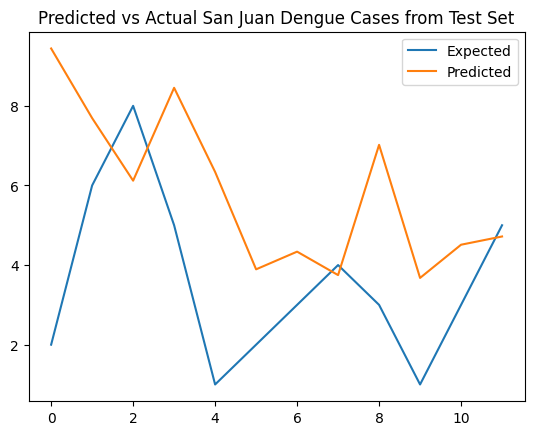

In [5]:
# transform the time series data into supervised learning
n_weeks = 1 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

# Select the proper columns from the output of series_to_supervised
# at 1 target and 14 features, you get 15 columns lagged and 15 columns unlagged
# 30 columns in total.  Keep the lagged ones plus the unlagged target column.
n_obs = n_weeks * n_features
# grabs columns 0 to 14, the lagged target and inputs (input/features)
# and then only the 15th column from the end which is the unlagged target (output/target)
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
# Note it's no longer a "nice-looking" dataframe with column headers
# it's a list of arrays, which perhaps works better in walk_forward_validation (and its functions)
print(data_recombined)				

# evaluate
mae, y, yhat = walk_fwd_validation_rf(data_recombined, 12)
print('Test MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.title('Predicted vs Actual San Juan Dengue Cases from Test Set')
pyplot.legend()
pyplot.show()

### Multivariate Random Forest Timeseries Model with lag 4

With lagged input as first column: 
     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)   var6(t-4)  \
4          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
5          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
6          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
7          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
8          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        5.0  -0.138650   0.015420   0.211629   0.117343  297.765714   
932        1.0  -0.088900  -0.090033   0.223243   0.154186  297.878571   
933        2.0  -0.321400  -0.141200   0.110643   0.141014  297.595714   
934        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
935        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   

      var7(t-4)   var8(t-4)  var9(t-4)  var10(t-4)  ...     var6(t)  \
4   

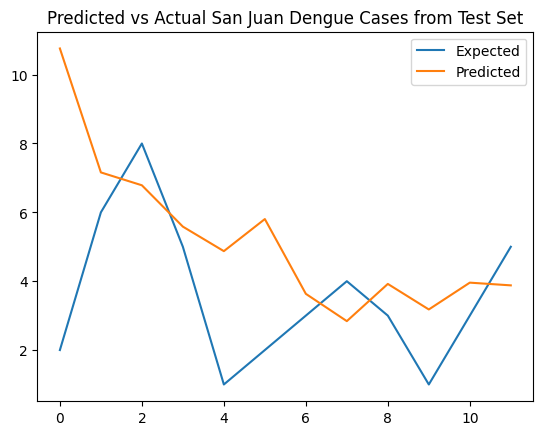

In [6]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

n_obs = n_weeks * n_features
# select X and y columns
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
print(data_recombined)				

# evaluate
mae, y, yhat = walk_fwd_validation_rf(data_recombined, 12)
print('Test MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.title('Predicted vs Actual San Juan Dengue Cases from Test Set')
pyplot.legend()
pyplot.show()

### Multivariate Random Forest Timeseries Model with lag 4  

Now let's increase the test size to 50 rows.  This may take time to produce the results.  

Took 40 minutes on my (presumably good-but-not-beefy) computer.

With lagged input as first column: 
     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)   var6(t-4)  \
4          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
5          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
6          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
7          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
8          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        5.0  -0.138650   0.015420   0.211629   0.117343  297.765714   
932        1.0  -0.088900  -0.090033   0.223243   0.154186  297.878571   
933        2.0  -0.321400  -0.141200   0.110643   0.141014  297.595714   
934        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
935        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   

      var7(t-4)   var8(t-4)  var9(t-4)  var10(t-4)  ...     var6(t)  \
4   

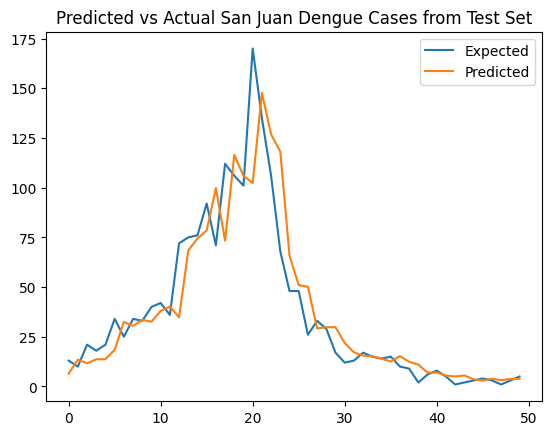

In [4]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

n_obs = n_weeks * n_features
# select X and y columns
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
print(data_recombined)				

# evaluate
mae, y, yhat = walk_fwd_validation_rf(data_recombined, 50)
print('Test MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.title('Predicted vs Actual San Juan Dengue Cases from Test Set')
pyplot.legend()
pyplot.show()

### Predicting on a Static Model  

The below mimics what's done above in the initial set-up where the model is trained on training data (after much processing), but now rather than:  
a) feed it one testX row at at time to do a real-time re-fit of the model and generate predictions one step at a time, instead we  
b) feed it the entire testX set of rows to get a 'static model' prediction, yhat_static, and get the model error on that   

In many situations, a real-time model re-fit may not be feasible if the computational load is too big, or data cannot be obtained in a timely manner to allow for real-time model updates.  Additionally, real-time model updates come with the additional burden of due diligence:  guardrails must be instituted to ensure 'rogue data' or significant drift in the process being modelled doesn't result in a model that produces significantly erroneous results.  Monitoring error would only be one part of the safeguarding scheme.  There would have to be additional supports like monitoring data quality real-time, among other protections.

Careful not to feed it [test_X], you want to feed it only (test_X) if you're sending it all of testX at a time.

The below trains a model with lag 4 as this yielded a lower MAE than the lag 1 model's MAE.

With lagged input as first column: 
     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)   var6(t-4)  \
4          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
5          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
6          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
7          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
8          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        5.0  -0.138650   0.015420   0.211629   0.117343  297.765714   
932        1.0  -0.088900  -0.090033   0.223243   0.154186  297.878571   
933        2.0  -0.321400  -0.141200   0.110643   0.141014  297.595714   
934        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
935        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   

      var7(t-4)   var8(t-4)  var9(t-4)  var10(t-4)  ...     var6(t)  \
4   

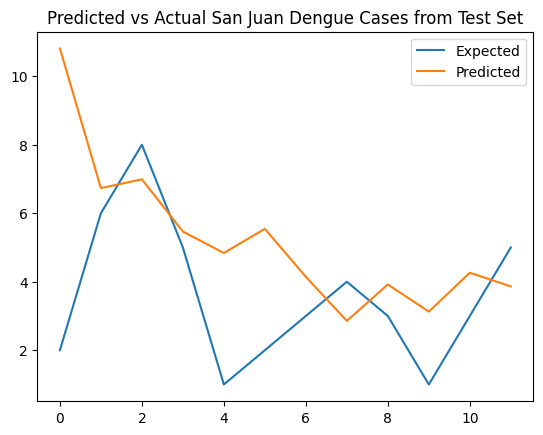

In [7]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

n_obs = n_weeks * n_features
# select X and y columns
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
print(data_recombined)	

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split_rows_reserved(data_recombined, 12)    
history = [x for x in train]
# the below is basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(test[:, -1], yhat_static_test)
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 12 to 50.  MAE went from 2.2 to 9.5, but that's ok.  Bit more in line with what I'm expecting vis-à-vis the results I'm getting from other models.  Plus now with a slighty smaller training set to fit on, and a larger test set to goof up on, I think it makes sense.

With lagged input as first column: 
     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)   var6(t-4)  \
4          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
5          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
6          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
7          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
8          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        5.0  -0.138650   0.015420   0.211629   0.117343  297.765714   
932        1.0  -0.088900  -0.090033   0.223243   0.154186  297.878571   
933        2.0  -0.321400  -0.141200   0.110643   0.141014  297.595714   
934        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
935        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   

      var7(t-4)   var8(t-4)  var9(t-4)  var10(t-4)  ...     var6(t)  \
4   

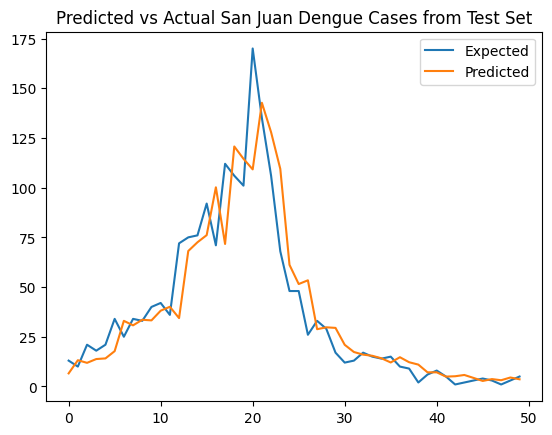

In [8]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

n_obs = n_weeks * n_features
# select X and y columns
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
print(data_recombined)	

# Split the data into a training set and a test set
train, test = train_test_split_rows_reserved(data_recombined, 50)    
history = [x for x in train]

# Divide the test set into X and y
testX, testy = test[:, :-1], test[:, -1]

history = asarray(history)        
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# predict y(t) using testX
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(test[:, -1], yhat_static_test)
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 50 to 100.  MAE 9.5 to 7.

With lagged input as first column: 
     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)   var6(t-4)  \
4          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
5          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
6          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
7          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
8          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        5.0  -0.138650   0.015420   0.211629   0.117343  297.765714   
932        1.0  -0.088900  -0.090033   0.223243   0.154186  297.878571   
933        2.0  -0.321400  -0.141200   0.110643   0.141014  297.595714   
934        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
935        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   

      var7(t-4)   var8(t-4)  var9(t-4)  var10(t-4)  ...     var6(t)  \
4   

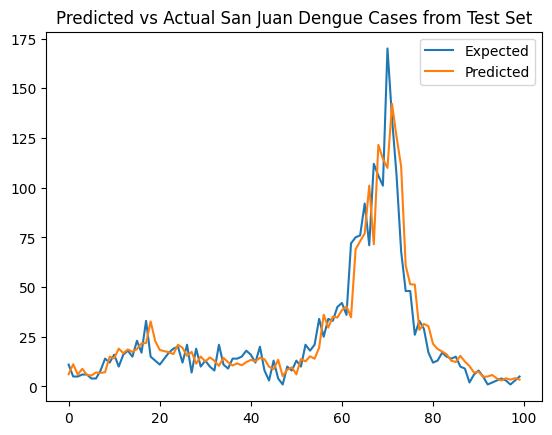

In [9]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

n_obs = n_weeks * n_features
# select X and y columns
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
print(data_recombined)	

# Split the data into a training set and a test set
train, test = train_test_split_rows_reserved(data_recombined, 100)    
history = [x for x in train]

# Divide the test set into X and y
testX, testy = test[:, :-1], test[:, -1]

history = asarray(history)        
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# predict y(t) using testX
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(test[:, -1], yhat_static_test)
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 100 to 200.  MAE 7 to 7.5.

With lagged input as first column: 
     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)   var6(t-4)  \
4          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
5          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
6          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
7          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
8          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        5.0  -0.138650   0.015420   0.211629   0.117343  297.765714   
932        1.0  -0.088900  -0.090033   0.223243   0.154186  297.878571   
933        2.0  -0.321400  -0.141200   0.110643   0.141014  297.595714   
934        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
935        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   

      var7(t-4)   var8(t-4)  var9(t-4)  var10(t-4)  ...     var6(t)  \
4   

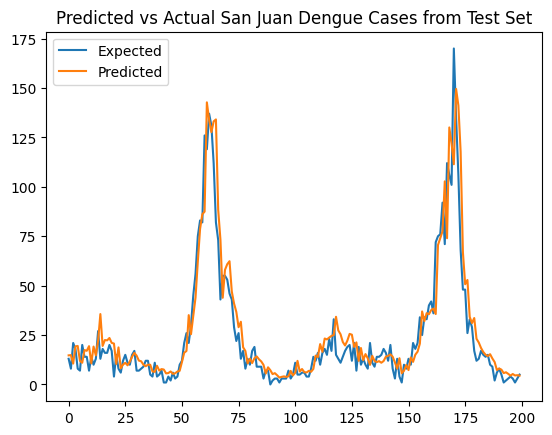

In [10]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

n_obs = n_weeks * n_features
# select X and y columns
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
print(data_recombined)	

# Split the data into a training set and a test set
train, test = train_test_split_rows_reserved(data_recombined, 200)    
history = [x for x in train]

# Divide the test set into X and y
testX, testy = test[:, :-1], test[:, -1]

history = asarray(history)        
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# predict y(t) using testX
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(test[:, -1], yhat_static_test)
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 200 to 300.  MAE 7.5 to 6.4.

With lagged input as first column: 
     var1(t-4)  var2(t-4)  var3(t-4)  var4(t-4)  var5(t-4)   var6(t-4)  \
4          4.0   0.122600   0.103725   0.198483   0.177617  297.572857   
5          5.0   0.169900   0.142175   0.162357   0.155486  298.211429   
6          4.0   0.032250   0.172967   0.157200   0.170843  298.781429   
7          3.0   0.128633   0.245067   0.227557   0.235886  298.987143   
8          6.0   0.196200   0.262200   0.251200   0.247340  299.518571   
..         ...        ...        ...        ...        ...         ...   
931        5.0  -0.138650   0.015420   0.211629   0.117343  297.765714   
932        1.0  -0.088900  -0.090033   0.223243   0.154186  297.878571   
933        2.0  -0.321400  -0.141200   0.110643   0.141014  297.595714   
934        3.0   0.044900   0.024450   0.101629   0.088000  297.404286   
935        4.0   0.077850  -0.039900   0.310471   0.296243  296.958571   

      var7(t-4)   var8(t-4)  var9(t-4)  var10(t-4)  ...     var6(t)  \
4   

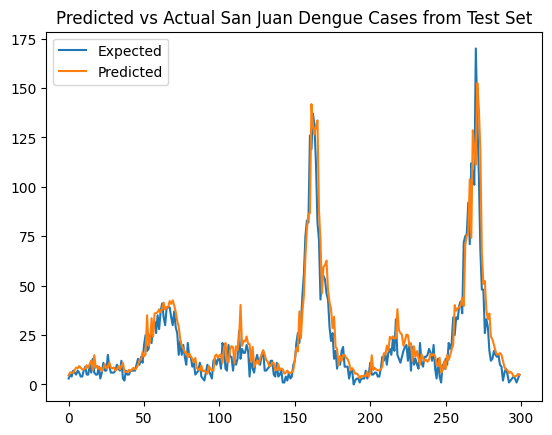

In [11]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)
print(f"With lagged input as first column: \n{data}")

n_obs = n_weeks * n_features
# select X and y columns
X_lagged = data.iloc[:, :n_obs].values
y_lagged = data.iloc[:, -n_features].values
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  
print(data_recombined)	

# Split the data into a training set and a test set
train, test = train_test_split_rows_reserved(data_recombined, 300)    
history = [x for x in train]

# Divide the test set into X and y
testX, testy = test[:, :-1], test[:, -1]

history = asarray(history)        
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# predict y(t) using testX
yhat_static_test = model_static.predict(testX)					
yhat_static_test	
#print('>Test expected=%.1f, Test predicted=%.1f' % (testy, yhat_static_test))
yhat_static_train = model_static.predict(trainX)					
yhat_static_train	
#print('>Train expected=%.1f, Train predicted=%.1f' % (trainy, yhat_static_train))

MAE_static_train = mean_absolute_error(trainy, yhat_static_train)
print('Training MAE on the static model: %.3f' % MAE_static_train)
MAE_static_test = mean_absolute_error(test[:, -1], yhat_static_test)
print('Test MAE on the static model: %.3f' % MAE_static_test)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(yhat_static_test, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()

## Hyperparameter Tuning using GridSearchCV  

What follows below is a printout of the last model's parameters, since it has a reasonable MAE given the train and test set sizes.  It provides us with a good starting point for setting up a hyperparameter tuning exercise.  

In [11]:
# Look at parameters used by our current forest
# Be sure the model_static being used below is the best one, ie. you run the lag 4 MV RF with test set 300 last if that's the best one.
print('Parameters currently in use:\n')
pprint(model_static.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


The parameter grid is adjusted for this model algorithm.

[[ 4.00000000e+00  1.22600000e-01  1.03725000e-01  1.98483300e-01  1.77616700e-01  2.97572857e+02  2.97742857e+02  2.92414286e+02  2.99800000e+02  2.95900000e+02  3.20000000e+01  7.33657143e+01  1.24200000e+01  1.40128571e+01  2.62857143e+00  5.00000000e+00  1.69900000e-01  1.42175000e-01  1.62357100e-01  1.55485700e-01  2.98211429e+02  2.98442857e+02  2.93951429e+02  3.00900000e+02  2.96400000e+02  1.79400000e+01  7.73685714e+01  2.28200000e+01  1.53728571e+01  2.37142857e+00  4.00000000e+00  3.22500000e-02  1.72966700e-01  1.57200000e-01  1.70842900e-01  2.98781429e+02  2.98878571e+02  2.95434286e+02  3.00500000e+02  2.97300000e+02  2.61000000e+01  8.20528571e+01  3.45400000e+01  1.68485714e+01  2.30000000e+00  3.00000000e+00  1.28633300e-01  2.45066700e-01  2.27557100e-01  2.35885700e-01  2.98987143e+02  2.99228571e+02  2.95310000e+02  3.01400000e+02  2.97000000e+02  1.39000000e+01  8.03371429e+01  1.53600000e+01  1.66728571e+01  2.42857143e+00  6.00000000e+00]
 [ 5.00000000e+00  1.

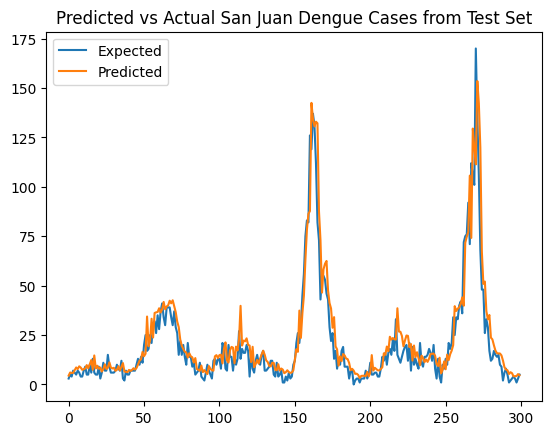

In [12]:
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised_mv(values, n_in=n_weeks)

# column selection
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)

# Split the data into a training set and a test set
train, test = train_test_split_rows_reserved(data_recombined, 300)    
history = [x for x in train]

# Divide the test set into X and y
testX, testy = test[:, :-1], test[:, -1]

history = asarray(history)        
trainX, trainy = history[:, :-1], history[:, -1]

# parameter grid suitable for random forest regression
param_grid = {'max_depth': [3, 5, 10],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [750, 1000, 1250],
             }

rf = RandomForestRegressor()

# Instantiate the GridSearchCV object, referencing the grid set up above.  
# We could alternatively use RandomizedSearchCV if we find this takes too long to run
grid = GridSearchCV(estimator=rf, param_grid=param_grid,
                    cv=5, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, refit=True)

grid.fit(trainX, trainy)

best_train_mae = grid.best_score_
best_params = grid.best_params_

print(
    f'The best hyperparameter settings achieve a cross-validated MAE of: {best_train_mae}.')

# Scikit learn automatically retrains the model on the entire training set after cross-validation by applying the best hyperparameters (refit=True)

best_grid_model = grid.best_estimator_
y_pred = best_grid_model.predict(testX)
y_pred_train = best_grid_model.predict(trainX)
MAE_test = mean_absolute_error(testy, y_pred)
print(f'Best grid model MAE on the test set:\t{MAE_test}')
MAE_train = mean_absolute_error(trainy, y_pred_train)
print('Best grid model MAE on the training set:\t %.5f' % MAE_train)

# plot actual and predicted
pyplot.plot(testy, label='Expected')
pyplot.plot(y_pred, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases from Test Set")
pyplot.legend()
pyplot.show()